In [1]:
import os
from os import walk
import copy
import picklex`

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim

In [2]:
# check if files can be opened
print(os.listdir("./"))

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


['.DS_Store', 'test_v1.pth', 'data_32', 'data_256', 'README.md', '.gitignore', '351.ipynb', '.ipynb_checkpoints', '.git']
PyTorch Version:  2.0.0
Torchvision Version:  0.15.0


In [3]:
calc_transform = transforms.Compose([transforms.ToTensor()])
calc_dataset = datasets.ImageFolder("./data_256/art_pictures/train",
                               transform=calc_transform)

calc_loader = torch.utils.data.DataLoader(calc_dataset, batch_size=32, shuffle=False, num_workers=2)

In [6]:
# Only need to preprocess once
# here are the results
# mean: tensor([0.5162, 0.4644, 0.3975])
# std:  tensor([0.2728, 0.2641, 0.2575])

def get_mean_std(loader):
    chan_sum, chan_sq_sum, num_batch = 0, 0, 0
    for data, _ in tqdm(loader):
        chan_sum += torch.mean(data, dim=[0,2,3])
        chan_sq_sum += torch.mean(data**2, dim=[0,2,3])
        num_batch += 1
    mean = chan_sum/num_batch
    std = (chan_sq_sum/num_batch - mean**2) ** 0.5
    return mean, std

mean, std = get_mean_std(calc_loader)
print('mean: '  + str(mean))
print('std:  '  + str(std))

100%|███████████████████████████████████████| 1563/1563 [00:58<00:00, 26.87it/s]

mean: tensor([0.5163, 0.4644, 0.3975])
std:  tensor([0.2728, 0.2641, 0.2575])


In [4]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize([0.5162, 0.4644, 0.3975], 
                                                     [0.2728, 0.2641, 0.2575])])
dataset = datasets.ImageFolder("./data_256/art_pictures/train",
                               transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, 
                                         shuffle=True, num_workers=2)

In [5]:
labels_map = {
    0: "art_nouveau",
    1: "baroque",
    2: "expressionism",
    3: "impressionism",
    4: "post_impressionism",
    5: "realism",
    6: "renaissance",
    7: "romanticism",
    8: "surrealism",
    9: "ukiyo_e",
}

In [25]:
# Get one batch
images, labels = next(iter(dataloader))
images1, labels1 = next(iter(calc_loader))
print(images[1].size())

torch.Size([3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


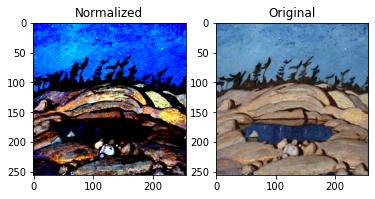

In [27]:
# see some pictures
some_index = 7

fig, axs = plt.subplots(1,2)
plt.title(labels_map[labels[some_index].item()])
axs[0].set_title('Normalized')
axs[1].set_title('Original')
axs[0].imshow(images[some_index].permute(1,2,0))
axs[1].imshow(images1[some_index].permute(1,2,0))


## Notes about Conv2d

<br>

### Parameters:
* in_channels (int) <br>
    * Number of channels in the input image<br>
* out_channels (int) <br>
    * Number of channels produced by the convolution<br>
* kernel_size (int or tuple)<br>
    * Size of the convolving kernel<br><br>

* stride (int or tuple, optional) <br>
    * Stride of the convolution. Default: 1<br>
* padding (int or tuple, optional) <br>
    * Zero-padding added to both sides of the input. Default: 0<br>
* padding_mode (string, optional) <br>
    * ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’<br>
* dilation (int or tuple, optional) <br>
    * Spacing between kernel elements. Default: 1<br>
* groups (int, optional) <br>
    * Number of blocked connections from input channels to output channels. Default: 1<br>
* bias (bool, optional) <br>
    * If True, adds a learnable bias to the output. Default: True<br>

<br>

### Output Size:  
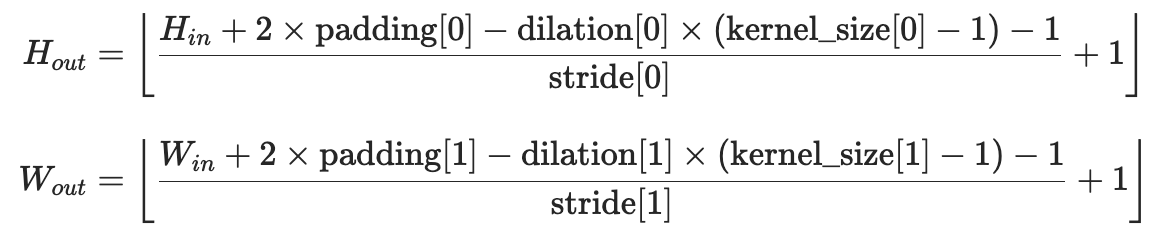



In [83]:
# implementation of VGG-BN for 3*256*256 inputs
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True))
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True))
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True))
        
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True))
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)
        
        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))
        
        self.conv9 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))
        
        self.conv10 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))
        
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)

        self.conv11 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))
        
        self.conv12 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))
        
        self.conv13 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))
        
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)

        
        self.adaptive = nn.AdaptiveAvgPool2d(output_size=(7,7))
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=25088, out_features = 4096, bias = True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.3, inplace = False))
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features = 4096, bias = True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.3, inplace = False))
        
        self.fc3 = nn.Linear(in_features=4096, out_features = 10, bias = True)
        
    def forward(self, x):
        x = self.conv1(x) 
        x = self.conv2(x) 
        x = self.pool1(x) 
        x = self.conv3(x) 
        x = self.conv4(x) 
        x = self.pool2(x) 
        x = self.conv5(x) 
        x = self.conv6(x)   
        x = self.conv7(x)  
        x = self.pool3(x) 
        x = self.conv8(x) 
        x = self.conv9(x) 
        x = self.conv10(x)
        x = self.pool4(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.pool5(x)
        x = self.adaptive(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_s

In [84]:
summary(net, input_size = (32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 10]                  --
├─Sequential: 1-1                        [32, 64, 256, 256]        --
│    └─Conv2d: 2-1                       [32, 64, 256, 256]        1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 256, 256]        128
│    └─ReLU: 2-3                         [32, 64, 256, 256]        --
├─Sequential: 1-2                        [32, 64, 256, 256]        --
│    └─Conv2d: 2-4                       [32, 64, 256, 256]        36,928
│    └─BatchNorm2d: 2-5                  [32, 64, 256, 256]        128
│    └─ReLU: 2-6                         [32, 64, 256, 256]        --
├─MaxPool2d: 1-3                         [32, 64, 128, 128]        --
├─Sequential: 1-4                        [32, 128, 128, 128]       --
│    └─Conv2d: 2-7                       [32, 128, 128, 128]       73,856
│    └─BatchNorm2d: 2-8                  [32, 128, 128, 128]       256
│

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [82]:
num_epoch = 50
total_step = len(dataloader)
stats = np.empty((0,3), float)

for epoch in tqdm(range(num_epoch)):  # loop over the dataset multiple times
    running_loss = 0.0
    running_correct = 0
    print('------ Starting Epoch [{}/{}] ------'.format(epoch+1, num_epoch))
    for i, data in tqdm(enumerate(dataloader, 0)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        
        # back prop
        loss.backward()
        optimizer.step()

        # stats
        running_loss += loss.item()*inputs.size(0)
        running_correct += torch.sum(preds == labels)
        stats = np.vstack((stats, np.array([running_loss, running_correct, (i+1)*32])))
        
        if(i % 300  == 1):
            print('Epoch [{}/{}], Step [{}/{}], Running Loss: {:.4f}, running Correct: [{}/{}]'
              .format(epoch+1, num_epoch, i+1, total_step, running_loss, running_correct, (i+1)*32))
    
    #save trained model every 5 epochs
    if(epoch % 5 == 4):
        PATH = './epoch_{}.pth'.format(epoch+1)
        torch.save(net.state_dict(), PATH)
        
print('Finished Training')

  0%|                                                     | 0/3 [00:00<?, ?it/s]

------ Starting Epoch [1/3] ------



0it [00:00, ?it/s]
1it [01:19, 79.98s/it]
  0%|                                                     | 0/3 [01:35<?, ?it/s]


KeyboardInterrupt: 

In [11]:
import pandas as pd
DF = pd.DataFrame(stats)
DF.to_csv("stats.csv")

In [17]:
test_set = datasets.ImageFolder("./data_256/art_pictures/test",
                               transform=transform)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True,batch_size=32)

In [33]:
correct = 0
total = 0
all_preds = np.empty((0,32), int)
all_labels = np.empty((0,32), int)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in tqdm(enumerate(testloader, 0)):
        
        test_images, test_labels = data
        # calculate outputs by running images through the network
        outputs = net(test_images)
        # the class with the highest energy is what we choose as prediction
        preds = torch.argmax(outputs, dim=1)
        total += test_labels.size(0)
        correct += torch.sum(preds == test_labels)
        
        all_preds = np.append(all_preds, preds.numpy())
        all_labels = np.append(all_labels, test_labels.numpy())

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

313it [08:26,  1.62s/it]

Accuracy of the network on the 10000 test images: 40 %


/var/folders/_x/wr_809dd1fn6w0377xcj_jnh0000gn/T/ipykernel_28008/1340801713.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axis_label)
/var/folders/_x/wr_809dd1fn6w0377xcj_jnh0000gn/T/ipykernel_28008/1340801713.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(axis_label)


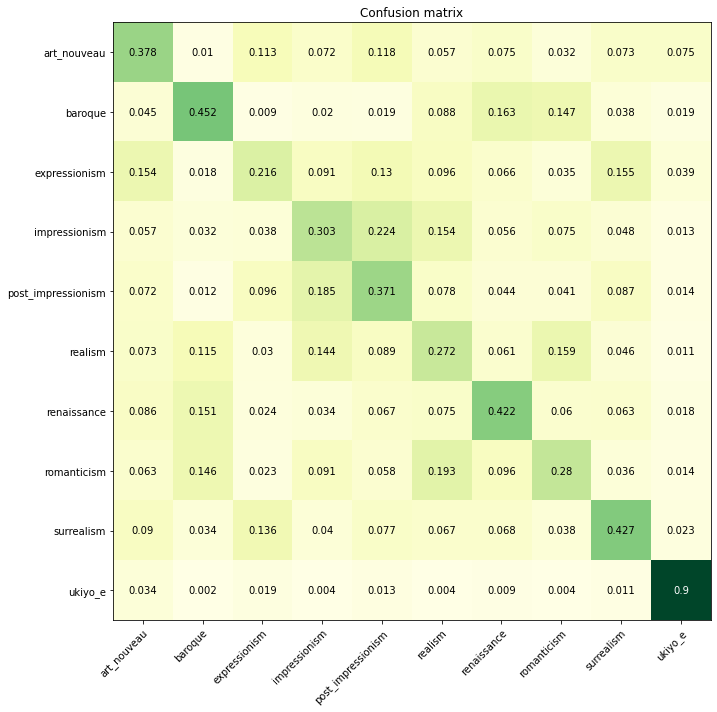

In [72]:
from torchmetrics.classification import MulticlassConfusionMatrix
import matplotlib
import matplotlib as mpl

axis_label =   ["art_nouveau",
                "baroque",
                "expressionism",
                "impressionism",
                "post_impressionism",
                "realism",
                "renaissance",
                "romanticism",
                "surrealism",
                "ukiyo_e"]

confmat = MulticlassConfusionMatrix(task="multiclass", num_classes=10)
confmat = confmat(torch.from_numpy(all_preds), torch.from_numpy(all_labels))
confmat.numpy()
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(confmat, cmap="YlGn")
ax.set_xticklabels(axis_label)
ax.set_yticklabels(axis_label)
ax.set_xticks(np.arange(len(axis_label)))
ax.set_yticks(np.arange(len(axis_label)))

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(axis_label)):
    for j in range(len(axis_label)):
        if((i == j) and (i == 9)):
            text = ax.text(j, i, confmat[i, j].numpy()/1000,
                           ha="center", va="center", color="#FFFFFF")
        else:
            text = ax.text(j, i, confmat[i, j].numpy()/1000,
                           ha="center", va="center", color="#000000")

ax.set_title("Confusion matrix")
fig.tight_layout()
plt.show()